In [1]:
# Copied most of this from https://www.oreilly.com/learning/algorithmic-trading-in-less-than-100-lines-of-python-code

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import oandapy

import configparser 
import oandapy as opy

%matplotlib inline
import seaborn as sns; sns.set()

import torch

ModuleNotFoundError: No module named 'oandapy'

In [3]:
def increase_by_percent(number,percent):
    return number + number*percent


In [4]:
start = 1
tithes = 0
for i in range(365):
    y = 0
    if i%7 == 0:
        y = start*.005
    tithes += y
    start=increase_by_percent(start,.02)-y
print(start)

1061.5826913463884


In [5]:
# check this out for news driven investing
#   https://arxiv.org/pdf/1807.06824.pdf

In [46]:
config = configparser.ConfigParser()  # 3
config.read('oanda.cfg')  # 4

oanda = opy.API(environment='practice', access_token=config['oanda']['access_token'])

In [48]:
data = oanda.get_history(instrument='EUR_USD',  # our instrument
                         start = '2016-12-08',  # start data
                         end='2016-12-10',      # end date
                         granularity='M1')      # minute bars  

df = pd.DataFrame(data['candles']).set_index('time')

df.index = pd.DatetimeIndex(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2658 entries, 2016-12-08 00:00:00 to 2016-12-09 21:59:00
Data columns (total 10 columns):
closeAsk    2658 non-null float64
closeBid    2658 non-null float64
complete    2658 non-null bool
highAsk     2658 non-null float64
highBid     2658 non-null float64
lowAsk      2658 non-null float64
lowBid      2658 non-null float64
openAsk     2658 non-null float64
openBid     2658 non-null float64
volume      2658 non-null int64
dtypes: bool(1), float64(8), int64(1)
memory usage: 210.3 KB


In [68]:
df['returns'] = np.log(df['closeAsk'] / df['closeAsk'].shift(1))

cols = [] 

for momentum in [15, 30, 60, 120]: 
    col = 'position_%s' % momentum  
    df[col] = np.sign(df['returns'].rolling(momentum).mean())  
    cols.append(col)  

C:\Users\munso\Anaconda3.1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sign
  import sys


In [69]:
cols

['position_15', 'position_30', 'position_60', 'position_120']

In [78]:
df[cols[0]][:120]

time
2016-12-08 00:00:00    NaN
2016-12-08 00:01:00    NaN
2016-12-08 00:02:00    NaN
2016-12-08 00:03:00    NaN
2016-12-08 00:04:00    NaN
2016-12-08 00:05:00    NaN
2016-12-08 00:06:00    NaN
2016-12-08 00:07:00    NaN
2016-12-08 00:08:00    NaN
2016-12-08 00:09:00    NaN
2016-12-08 00:10:00    NaN
2016-12-08 00:11:00    NaN
2016-12-08 00:12:00    NaN
2016-12-08 00:13:00    NaN
2016-12-08 00:14:00    NaN
2016-12-08 00:17:00    1.0
2016-12-08 00:18:00    1.0
2016-12-08 00:19:00    1.0
2016-12-08 00:20:00    1.0
2016-12-08 00:21:00    1.0
2016-12-08 00:23:00   -1.0
2016-12-08 00:24:00   -1.0
2016-12-08 00:25:00   -1.0
2016-12-08 00:26:00   -1.0
2016-12-08 00:27:00   -1.0
2016-12-08 00:29:00   -1.0
2016-12-08 00:31:00   -1.0
2016-12-08 00:32:00   -1.0
2016-12-08 00:33:00   -1.0
2016-12-08 00:35:00    1.0
                      ... 
2016-12-08 01:38:00    1.0
2016-12-08 01:39:00    1.0
2016-12-08 01:40:00    1.0
2016-12-08 01:41:00    1.0
2016-12-08 01:42:00    1.0
2016-12-08 01:43:00    

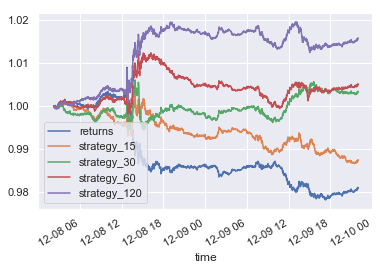

In [81]:
strats = ['returns']  # 19

for col in cols:  # 20
    strat = 'strategy_%s' % col.split('_')[1]
    df[strat] = df[col].shift(1) * df['returns']
    strats.append(strat)

df[strats].dropna().cumsum().apply(np.exp).plot()

In [82]:
class MomentumTrader(opy.Streamer):
    def __init__(self, momentum, *args, **kwargs):
        opy.Streamer.__init__(self, *args, **kwargs)
        self.ticks = 0 
        self.position = 0 
        self.df = pd.DataFrame()  
        self.momentum = momentum  
        self.units = 100000  
    def create_order(self, side, units):  
        order = oanda.create_order(config['oanda']['account_id'], 
            instrument='EUR_USD', units=units, side=side,
            type='market')  
        print('\n', order)  
    def on_success(self, data):  
        self.ticks += 1  
        # print(self.ticks, end=', ')
        # appends the new tick data to the DataFrame object
        self.df = self.df.append(pd.DataFrame(data['tick'],
                                 index=[data['tick']['time']]))  
        # transforms the time information to a DatetimeIndex object
        self.df.index = pd.DatetimeIndex(self.df['time'])  
        # resamples the data set to a new, homogeneous interval
        dfr = self.df.resample('5s').last()  
        # calculates the log returns
        dfr['returns'] = np.log(dfr['ask'] / dfr['ask'].shift(1))  
        # derives the positioning according to the momentum strategy
        dfr['position'] = np.sign(dfr['returns'].rolling( 
                                      self.momentum).mean())  
        if dfr['position'].ix[-1] == 1:  
            # go long
            if self.position == 0:  
                self.create_order('buy', self.units)  
            elif self.position == -1:  
                self.create_order('buy', self.units * 2)  
            self.position = 1  
        elif dfr['position'].ix[-1] == -1:  
            # go short
            if self.position == 0: 
                self.create_order('sell', self.units)  
            elif self.position == 1: 
                self.create_order('sell', self.units * 2)  
            self.position = -1  
        if self.ticks == 250:  
            # close out the position
            if self.position == 1:  
                self.create_order('sell', self.units) 
            elif self.position == -1:  
                self.create_order('buy', self.units)
            self.disconnect()  

In [86]:
mt = MomentumTrader(momentum=12, environment='practice',
                    access_token=config['oanda']['access_token'])

In [92]:
mt.rates(account_id=config['oanda']['account_id'],
         instruments=["DE30_EUR"], ignore_heartbeat=True)

JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)